In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mrf import display

import pandas as pd
from astropy.io import fits

from DFDetect import DWFS_mrf, detect
import os


from astropy.modeling.functional_models import Sersic2D
import astropy.units as u
from astropy.convolution import convolve_fft
from scipy.ndimage import zoom
from skimage.measure import block_reduce

#Locations of needed files
band = 'G'
tile_name = 'tile_223.647_-1.424_SloanG'
DF_file = DWFS_mrf.tile_dir + tile_name + '_g.fits'
config_file = '/home/tbm33/projects/packages/DragonflyWideSurvey/df_decals_g.yaml'
decals_g_file = DWFS_mrf.decals_dir + tile_name + '_decals_cutout_g.fits'
decals_r_file = DWFS_mrf.decals_dir + tile_name + '_decals_cutout_r.fits'


In [4]:
#Rough gauss of UDG-like parameters, Obviously will change these and run a bunch of parameters
ser_ind = 0.75
re_phys = 3*u.kpc
D = 75*u.Mpc
re_ang = (re_phys/D *u.rad).to(u.arcsec).value
re_pix = re_ang / 2.5
mu_e = 25
Zpt = 27#ish
Ie = 10**( (mu_e - 5*np.log10(2.5)- Zpt) / -2.5)

psf_pix = np.load('psf_ex.npy')

#Render at higher resolution to ensure accurate profile since size~pixel
zoom_fac = 5
size_pix_DF = int(10*re_pix) + 1
size_zoom = size_pix_DF*5
Xz,Yz = np.meshgrid(np.arange(size_zoom), np.arange(size_zoom))
ser_func = Sersic2D(amplitude = Ie, r_eff = re_pix*zoom_fac, n = ser_ind, x_0 = size_zoom /2., y_0 = size_zoom/2.)
zoom_intr = ser_func(Xz,Yz)
zoom_conv = convolve_fft(zoom_intr, zoom(psf_pix,zoom_fac))
gal_img = block_reduce(zoom_conv, (zoom_fac,zoom_fac), func = np.mean)

In [5]:
df_fits = fits.open(DF_file)
df_IR= df_fits[0].data.copy()
coord = []
for i in range(100):
    x = np.random.randint(30,920)
    y = np.random.randint(30,920)
    df_IR[x:x+gal_img.shape[0], y:y+gal_img.shape[1]] += gal_img
    coord.append([x,y])

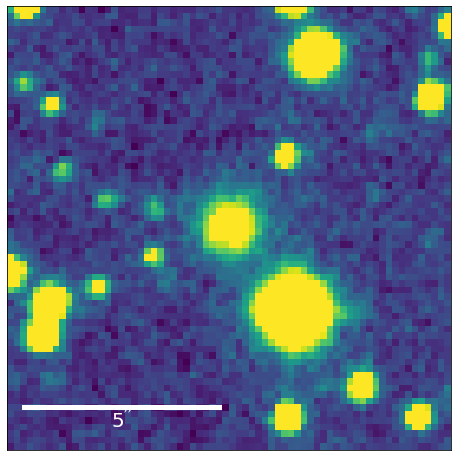

In [8]:
%matplotlib inline
ind = 8
display.display_single(df_IR[coord[ind][0]-17:coord[ind][0]+51,coord[ind][1]-17:coord[ind][1]+51 ])
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


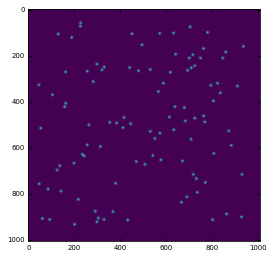

In [10]:
plt.imshow(df_IR-df_fits[0].data)
plt.show()

In [11]:
hdu = fits.PrimaryHDU(df_IR)
hdu.header = df_fits[0].header
IR_file = './%s_IR_1.fits'%tile_name
hdu.writeto(IR_file,overwrite = True)

In [12]:
#You don't need the mast catalog but might be worth downloading if you plan on running on multiple tiles
res_IR = DWFS_mrf.run_mrf_tile(IR_file, band, config_file, './output_IR/', hires_g_file = decals_g_file, hires_r_file = decals_r_file, mast_file = DWFS_mrf.master_mast_catalog, use_two_bands = True,save_fig = True)

using master MAST catalog
2021-04-23 16:55:03,949 Running Multi-Resolution Filtering (MRF) on "decals" and "df" images!
2021-04-23 16:55:03,956 Subtract BACKVAL=632.7 of Dragonfly image
2021-04-23 16:55:03,965 Magnify Dragonfly image with a factor of 3.0:
2021-04-23 16:55:06,222 Register high resolution image "/netb/dokkum/data/DWFS/decals_frames/tile_223.647_-1.424_SloanG_decals_cutout_g.fits" with "./tile_223.647_-1.424_SloanG_IR_1.fits"
2021-04-23 16:55:21,392 Register high resolution image "/netb/dokkum/data/DWFS/decals_frames/tile_223.647_-1.424_SloanG_decals_cutout_r.fits" with "./tile_223.647_-1.424_SloanG_IR_1.fits"
2021-04-23 16:55:36,566 Build flux models on high-resolution images: Blue band
2021-04-23 16:55:36,567     - sigma = 2.0, minarea = 5
2021-04-23 16:55:36,568     - deblend_cont = 0.00500, deblend_nthres = 32.0
2021-04-23 16:55:38,880     - Detect 9784 objects
2021-04-23 16:55:43,403 Build flux models on high-resolution images: Red band
2021-04-23 16:55:43,404     - 

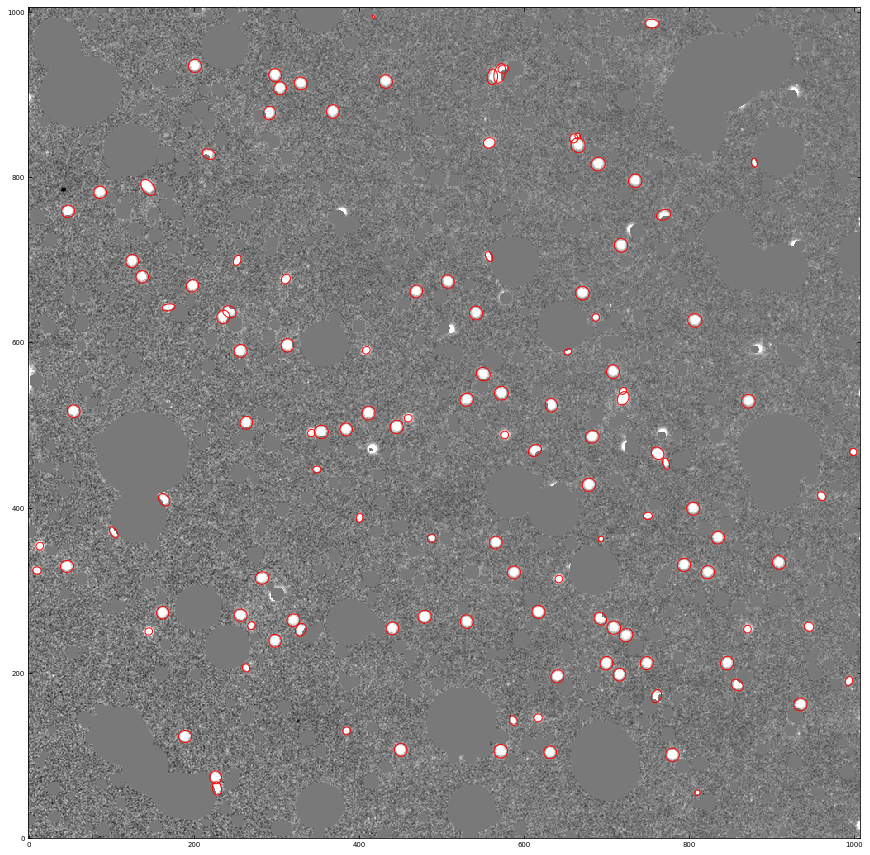

In [13]:
%matplotlib inline
obj_IR = detect.detect_sources(res_IR.lowres_final.image, 10, 'g',  res_IR.lowres_final.wcs,search_radius = 3., mask = res_IR.lowres_mask.image)
plt.show()

In [14]:
num_match = 0
for coord_cur in coord:
    is_close = (np.abs(obj_IR['x'] - coord_cur[1]-17) < 1)*( np.abs(obj_IR['y']- (coord_cur[0]+17) ) < 1)
    if np.sum(is_close) == 1:
        num_match += 1
    elif np.sum(is_close) > 1:
        print('More then 1 ?')
print (num_match,'/',len(coord) )

75 / 100


In [15]:
print ('frac recoved = %.2f +/- %.2f'%(num_match/len(coord),np.sqrt(num_match)/len(coord)) )

frac recoved = 0.75 +/- 0.09


In [16]:
frac_masked = np.sum(res_IR.lowres_mask.image)/ (res_IR.lowres_mask.image.shape[0]*res_IR.lowres_mask.image.shape[1] )
1-frac_masked

0.8031613856924074